# Introduction to the Low-salt-rejection Reverse Osmosis (LSRRO) Flowsheet
This tutorial shows how to build, initialize, simulate, and optimize an LSRRO flowsheet using WaterTAP.

<center><img src="graphics/lsrro_flowsheet.png" width="1100" height="600"></center>

## High-level Preview: Run an LSRRO optimization case. We will specify the following:
* 3-stage system (number_of_stages=3)
* System Water Recovery of 50% (water_recovery=0.50)
* 70 g/L TDS feed (Cin=70) 
* Feed flow rate of 0.001 m3/s (Qin=1e-3)


In [1]:
from watertap.flowsheets.lsrro.lsrro import (
    ACase,
    BCase,
    ABTradeoff,
    run_lsrro_case,
)
import logging

logging.getLogger("idaes").setLevel(logging.ERROR)
logging.getLogger("pyomo").setLevel(logging.ERROR)

In [2]:
m, results = run_lsrro_case(
    number_of_stages=3,  # total number of stages
    water_recovery=0.50,  # overall water recovery
    Cin=70,  # inlet NaCl conc in kg/m3,
    Qin=1e-3,  # inlet feed flowrate in m3/s
    permeate_quality_limit=1000e-6,  # permeate quality limit in ppm
    quick_start=True,  # skip rigorous initialization procedure for quick results (increased risk of non-convergence)
)


***---Simulation results---***
Simulation failed. The current configuration is infeasible. Please adjust the decision variables.

***---Optimization results---***
----system metrics----
Feed: 1.05 kg/s, 66946 ppm
Product: 0.498 kg/s, 1000 ppm
Brine: 0.548 kg/s, 126890 ppm
Volumetric water recovery: 50.0%
Number of Stages: 3
Total Membrane Area: 261.39
Energy Consumption: 6.6 kWh/m3
Levelized cost of water: 1.55 $/m3
Primary Pump Capital Cost ($/m3): 0.48
Booster Pump Capital Cost ($/m3): 0.10
ERD Capital Cost ($/m3): 0.04
Membrane Capital Cost ($/m3): 0.14
Indirect Capital Cost ($/m3): 0.38
Electricity cost ($/m3): 0.46


--decision variables--
Stage 1 operating pressure 85.0 bar
Stage 1 membrane area      155.3 m2
Stage 1 water perm. coeff.  1.5 LMH/bar
Stage 1 salt perm. coeff.  0.1 LMH
Stage 2 operating pressure 65.0 bar
Stage 2 membrane area      105.0 m2
Stage 2 water perm. coeff.  1.5 LMH/bar
Stage 2 salt perm. coeff.  15.3 LMH
Stage 3 operating pressure 65.0 bar
Stage 3 membran

## Overview of setting up and optimizing the LSRRO flowsheet
* Step 0: Import Python libraries.

* Step 1: Build the LSRRO flowsheet.

* Step 2: Set specifications for LSRRO flowsheet.

* Step 3: Initialize the LSRRO flowsheet.

* Step 4: Optimize the LSRRO flowsheet.

* Step 5: Visualize results.

## Step 0: Import libraries.

In [3]:
# Import LSRRO flowsheet module
from watertap.flowsheets.lsrro import lsrro

## Step 1: Build the LSRRO flowsheet.

In [4]:
# Create a Pyomo concrete model, flowsheet, and NaCl property parameter block.
m = lsrro.build(
    number_of_stages=3,
    has_NaCl_solubility_limit=True,
    has_calculated_concentration_polarization=True,
    has_calculated_ro_pressure_drop=True,
    number_of_RO_finite_elements=10,
)

## Step 2: Set specifications for the LSRRO flowsheet.

In [5]:
lsrro.set_operating_conditions(m)

In [6]:
# Uncomment the following line to display the specified conditions of the model
# lsrro.display_operating_conditions(m)

## Step 3: Initialize the LSRRO flowsheet model.

In [7]:
lsrro.initialize(m)

--------------------START FORWARD INITIALIZATION PASS--------------------
--------------------START BACKWARD INITIALIZATION PASS--------------------
--------------------START FORWARD INITIALIZATION PASS--------------------
INFO: Starting Sequential Decomposition
INFO: Starting first pass run of network
2026-01-06 11:14:13 [INFO] idaes.init.fs.feed: Initialization Complete.
2026-01-06 11:14:14 [INFO] idaes.init.fs.PrimaryPumps[1].control_volume: Initialization Complete
2026-01-06 11:14:14 [INFO] idaes.init.fs.PrimaryPumps[1]: Initialization Complete: optimal - Optimal Solution Found
2026-01-06 11:14:14 [INFO] idaes.init.fs.Mixers[1]: Initialization Complete: optimal - Optimal Solution Found
2026-01-06 11:14:14 [INFO] idaes.init.fs.ROUnits[1].feed_side: Initialization Complete
2026-01-06 11:14:16 [INFO] idaes.init.fs.ROUnits[1]: Initialization Complete: optimal - Optimal Solution Found
2026-01-06 11:14:16 [INFO] idaes.init.fs.EnergyRecoveryDevices[1].control_volume: Initialization Comple

## Step 4: Simulate the LSRRO flowsheet.

In [8]:
lsrro.solve(m, tee=False, raise_on_failure=True)

print("Simulation Results:\n")
lsrro.display_system(m)

Simulation Results:

----system metrics----
Feed: 1.05 kg/s, 66946 ppm
Product: 0.349 kg/s, 751 ppm
Brine: 0.697 kg/s, 100084 ppm
Volumetric water recovery: 35.0%
Number of Stages: 3
Total Membrane Area: 183.33
Energy Consumption: 10.4 kWh/m3
Levelized cost of water: 2.41 $/m3
Primary Pump Capital Cost ($/m3): 0.83
Booster Pump Capital Cost ($/m3): 0.17
ERD Capital Cost ($/m3): 0.07
Membrane Capital Cost ($/m3): 0.14
Indirect Capital Cost ($/m3): 0.60
Electricity cost ($/m3): 0.73




In [9]:
# store LCOW breakdown values from simulation results
lcow_breakdown_results, case_list = lsrro.get_lcow_breakdown(
    m, new_case="Simulated Results"
)

In [10]:
lcow_breakdown_results

{'Membrane CAPEX': [0.07201792002054254],
 'Pump CAPEX': [0.49818640011410525],
 'ERD CAPEX': [0.032699960698051235],
 'Indirect CAPEX': [0.6029042808326991],
 'Membrane OPEX': [0.1512376320431393],
 'Electricity': [0.7309236776200411],
 'Other OPEX': [0.3185318164872939]}

## Step 5: Optimize the LSRRO flowsheet.

In [11]:
lsrro.optimize_set_up(
    m,
    water_recovery=0.5,
    A_case=ACase.optimize,  # water permeability coefficient
    B_case=BCase.optimize,  # salt permeability coefficient
    AB_tradeoff=ABTradeoff.equality_constraint,  # water and salt permeability equality constraints
    permeate_quality_limit=1000e-6,
)
optimization_results = lsrro.solve(m, raise_on_failure=True)

In [12]:
print("Optimization Results:\n")
lsrro.display_system(m)

Optimization Results:

----system metrics----
Feed: 1.05 kg/s, 66946 ppm
Product: 0.498 kg/s, 1000 ppm
Brine: 0.548 kg/s, 126890 ppm
Volumetric water recovery: 50.0%
Number of Stages: 3
Total Membrane Area: 265.86
Energy Consumption: 7.6 kWh/m3
Levelized cost of water: 1.71 $/m3
Primary Pump Capital Cost ($/m3): 0.50
Booster Pump Capital Cost ($/m3): 0.13
ERD Capital Cost ($/m3): 0.04
Membrane Capital Cost ($/m3): 0.14
Indirect Capital Cost ($/m3): 0.41
Electricity cost ($/m3): 0.53




In [13]:
lcow_breakdown_results, case_list = lsrro.get_lcow_breakdown(
    m,
    new_case="Optimization Results",
    existing_case_list=case_list,
    results=lcow_breakdown_results,
)

## Step 6: Visualize results

### Compare the breakdown of levelized cost of water for simulated and optimized results.


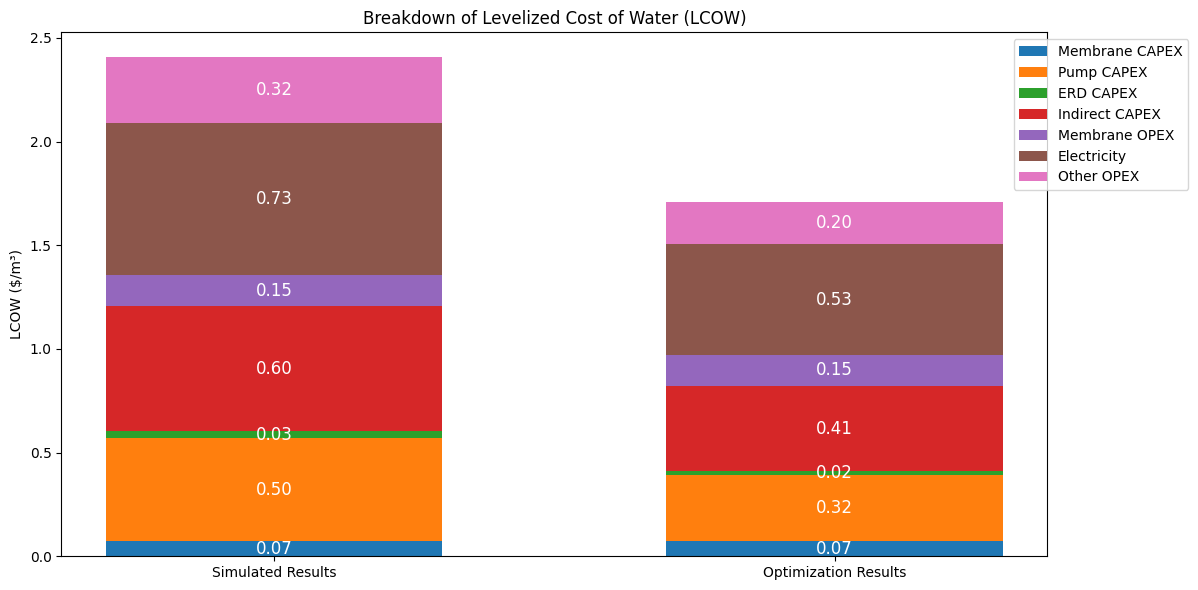

In [14]:
lsrro.plot_lcow_breakdown(lcow_breakdown_results, scenario_labels=case_list)

## 

### Conduct sensitivity analysis on feed concentration and water recovery rate and visualize optimal levelized cost of water.
#### Running cases with feedwater concentration ranging from 70 to 150 g/L TDS and recovery rates from 20% to 50%.

<div class="alert alert-block alert-info">
<b>Note:</b> Generating each of the following figures may take several minutes.
</div>

#### Results for a 3-stage LSRRO system

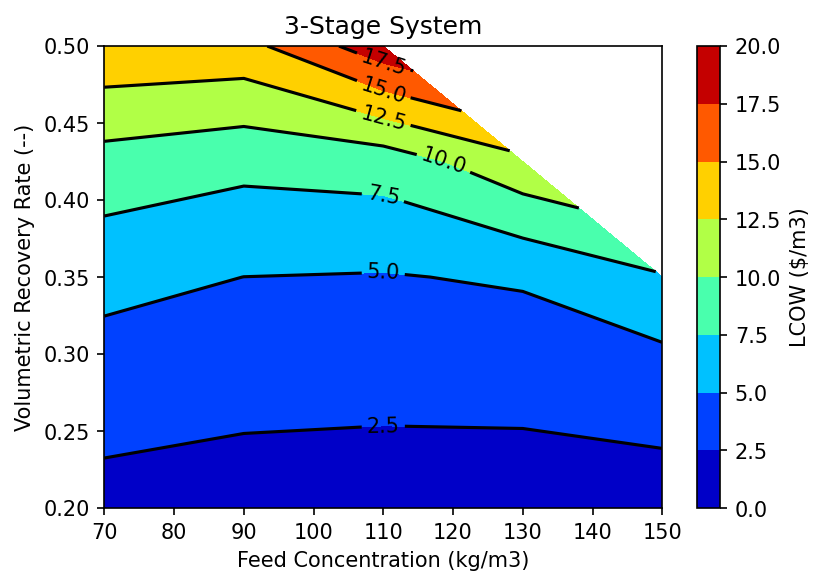

In [15]:
results3, _, fig3, ax3 = lsrro.feed_concentration_recovery_profile(
    m=m, number_of_stages=3, points_per_sweep=5
)

## 

In [16]:
import pandas as pd

# Show all rows and columns for 3-stage sweep results
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

results3

,# Feed Concentration,Volumetric Recovery Rate,LCOW,LCOW wrt Feed Flow,SEC,SEC wrt Feed,Number of Stages,Final Brine Concentration,Final Permeate Concentration (ppm),Annual Feed Flow,Annual Water Production,Pump Work In (kW),Pump Work Recovered (kW),Net Pump Work In (kW),Energy Recovery (%),Mass Water Recovery Rate (%),System Salt Rejection (%),Total Membrane Area,Total Capex LCOW,Total Opex LCOW,Primary Pump Capex LCOW,Booster Pump Capex LCOW,ERD Capex LCOW,Membrane Capex LCOW,Indirect Capex LCOW,Electricity LCOW,Membrane Replacement LCOW,Chem-labor-maintenance LCOW,Pumping Energy Agg LCOW,Membrane Agg LCOW,Feed Pressure (psi)-Stage 1,Feed Pressure (psi)-Stage 2,Feed Pressure (psi)-Stage 3,Pump Feed Flowrate-Stage 1 (gpm),Pump Feed Flowrate-Stage 2 (gpm),Pump Feed Flowrate-Stage 3 (gpm),Permeate flowrate-Stage 1 (gpm),Permeate flowrate-Stage 2 (gpm),Permeate flowrate-Stage 3 (gpm),Membrane Area-Stage 1,Membrane Area-Stage 2,Membrane Area-Stage 3,Total Membrane Length-Stage 1,Total Membrane Length-Stage 2,Total Membrane Length-Stage 3,Effective Membrane Width-Stage 1,Effective Membrane Width-Stage 2,Effective Membrane Width-Stage 3,Observed Rejection (%)-Stage 1,Observed Rejection (%)-Stage 2,Observed Rejection (%)-Stage 3,Observed Salt Passage (%)-Stage 1,Observed Salt Passage (%)-Stage 2,Observed Salt Passage (%)-Stage 3,Mass Salt Passage (%)-Stage 1,Mass Salt Passage (%)-Stage 2,Mass Salt Passage (%)-Stage 3,Volumetric Module Recovery Rate (%)-Stage 1,Volumetric Module Recovery Rate (%)-Stage 2,Volumetric Module Recovery Rate (%)-Stage 3,Mass Water Module Recovery Rate (%)-Stage 1,Mass Water Module Recovery Rate (%)-Stage 2,Mass Water Module Recovery Rate (%)-Stage 3,Volumetric Stage Recovery Rate (%)-Stage 1,Volumetric Stage Recovery Rate (%)-Stage 2,Volumetric Stage Recovery Rate (%)-Stage 3,Mass Water Stage Recovery Rate (%)-Stage 1,Mass Water Stage Recovery Rate (%)-Stage 2,Mass Water Stage Recovery Rate (%)-Stage 3,A-Value (LMH/bar)-Stage 1,A-Value (LMH/bar)-Stage 2,A-Value (LMH/bar)-Stage 3,B-Value (LMH)-Stage 1,B-Value (LMH)-Stage 2,B-Value (LMH)-Stage 3,Average Water Flux (LMH)-Stage 1,Average Water Flux (LMH)-Stage 2,Average Water Flux (LMH)-Stage 3,Average NaCl Flux (GMH)-Stage 1,Average NaCl Flux (GMH)-Stage 2,Average NaCl Flux (GMH)-Stage 3,Pressure Drop (bar)-Stage 1,Pressure Drop (bar)-Stage 2,Pressure Drop (bar)-Stage 3,Inlet Reynolds Number-Stage 1,Inlet Reynolds Number-Stage 2,Inlet Reynolds Number-Stage 3,Outlet Reynolds Number-Stage 1,Outlet Reynolds Number-Stage 2,Outlet Reynolds Number-Stage 3,Inlet Crossflow Velocity-Stage 1,Inlet Crossflow Velocity-Stage 2,Inlet Crossflow Velocity-Stage 3,Outlet Crossflow Velocity-Stage 1,Outlet Crossflow Velocity-Stage 2,Outlet Crossflow Velocity-Stage 3,Primary Pump SEC-Stage 1,Primary Pump SEC-Stage 2,Primary Pump SEC-Stage 3,Booster Pump SEC-Stage 1,Booster Pump SEC-Stage 2,Booster Pump SEC-Stage 3,ERD SEC-Stage 1,ERD SEC-Stage 2,ERD SEC-Stage 3,Net SEC-Stage 1,Net SEC-Stage 2,Net SEC-Stage 3
0,70.0,0.200,1.705656,0.341131,7.719651,1.543930,3.0,87.19052,1000.0,28401.84,5680.368,10.57771,-5.019558,5.558149,47.45412,20.39255,98.57749,76.46976,0.845595,0.860062,0.321780,0.002449,0.054564,0.044005,0.422797,0.540376,0.066007,0.253678,1.525236,0.180420,1154.863,145.0379,145.0377,15.85032,12.81813,12.816840,3.170065,0.129069,0.127782,66.19227,5.160927,5.116561,7.053889,0.230969,0.231313,9.383798,22.344690,22.119660,98.57878,10.49413,10.48205,1.421217,89.50587,89.51795,0.281948,0.892364,0.892484,19.838460,0.996989,0.996989,20.228250,1.000000,1.000000,20.0,1.006928,0.996989,20.39255,1.009999,1.000000,1.512,15.12000,15.12000,0.126,46.07713,46.07713,10.82041,5.52758,5.519756,10.83124,442.3476,442.2612,0.923871,0.010465,0.010483,124.9259,41.75257,41.75292,98.43082,41.33243,41.33279,0.126393,0.043003,0.043008,0.101389,0.042575,0.042579,14.557730,8.949655e-08,1.565807e-03,0.0,0.118544,0.013417,-6.173164,0.0,-0.798444,8.384569,0.118544,-0.783462
1,70.0,0.275,1.589335,0.437067,7.

## Try It Yourself
**Task**: Generate a feed concentration recovery profile and show the tabulated results for a 5-stage system.

<details>
  <summary>Click the arrow for a hint!</summary>
    
Use the code for the 3-stage system as a starting point.
</details>

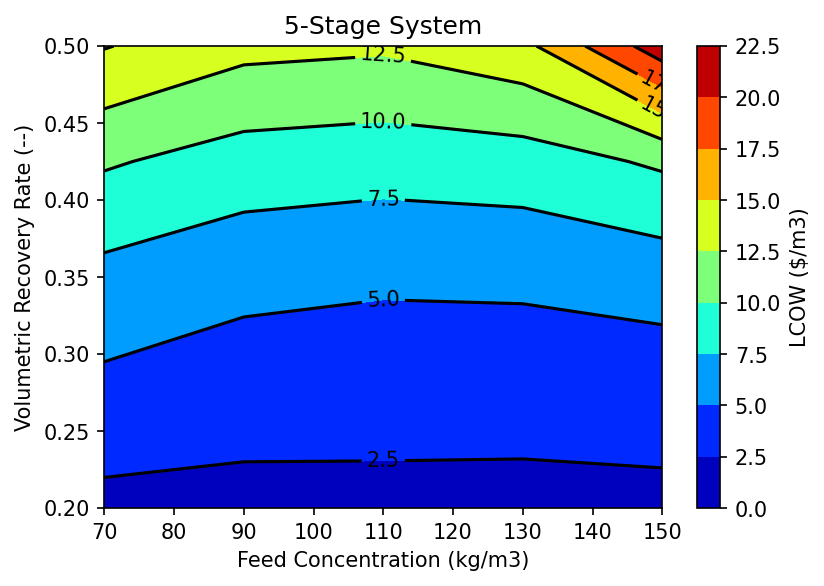

In [18]:
# Call the function to visualize the profile

# Display the tabulated sweep results


For more details on functions like `get_lcow_breakdown`, `plot_lcow_breakdown`, and `feed_concentration_recovery_profile`, please refer to the LSRRO flowsheet file in the WaterTAP repository: https://github.com/watertap-org/watertap/blob/main/watertap/flowsheets/lsrro/lsrro.py.